In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchonn as onn
from torchonn.models import ONNBaseModel
import torch.optim as optim
import torchvision.transforms as transforms
import scipy.stats as stats
from copy import deepcopy
from PIL import Image, ImageFilter
import os

2023-08-12 00:54:31,466 - butterfly_op.py[line:23] - WARNING: Import universal_cuda fail
2023-08-12 00:54:31,467 - butterfly_op.py[line:27] - WARNING: Import hadamard_cuda fail
2023-08-12 00:54:31,468 - matrix_parametrization.py[line:23] - WARNING: Cannot import matrix_parametrization_cuda. Decomposers can only work on CPU mode


In [2]:
from learner import Learner
config = [
        ('conv2d', [64, 1, 3, 3, 2, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('conv2d', [64, 64, 3, 3, 2, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('conv2d', [64, 64, 3, 3, 2, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('conv2d', [64, 64, 2, 2, 1, 0]),
        ('relu', [True]),
        ('bn', [64]),
        ('flatten', []),
        ('linear', [5, 64])
    ]

In [3]:
class OmniglotNShot:

    def __init__(self, root, batchsz, n_way, k_shot, k_query, imgsz):
        """
        Different from mnistNShot, the
        :param root:
        :param batchsz: task num
        :param n_way: 
        :param k_shot:
        :param k_qry:
        :param imgsz:
        """

        self.resize = imgsz
        if not os.path.isfile(os.path.join(root, 'omniglot.npy')):
            # if root/data.npy does not exist, just download it
            self.x = Omniglot(root, download=True,
                              transform=transforms.Compose([lambda x: Image.open(x).convert('L'),
                                                            lambda x: x.resize((imgsz, imgsz)),
                                                            lambda x: np.reshape(x, (imgsz, imgsz, 1)),
                                                            lambda x: np.transpose(x, [2, 0, 1]),
                                                            lambda x: x/255.])
                              )

            temp = dict()  # {label:img1, img2..., 20 imgs, label2: img1, img2,... in total, 1623 label}
            for (img, label) in self.x:
                if label in temp.keys():
                    temp[label].append(img)
                else:
                    temp[label] = [img]

            self.x = []
            for label, imgs in temp.items():  # labels info deserted , each label contains 20imgs
                self.x.append(np.array(imgs))

            # as different class may have different number of imgs
            self.x = np.array(self.x).astype(np.float)  # [[20 imgs],..., 1623 classes in total]
            # each character contains 20 imgs
            print('data shape:', self.x.shape)  # [1623, 20, 84, 84, 1]
            temp = []  # Free memory
            # save all dataset into npy file.
            np.save(os.path.join(root, 'omniglot.npy'), self.x)
            print('write into omniglot.npy.')
        else:
            # if data.npy exists, just load it.
            self.x = np.load(os.path.join(root, 'omniglot.npy'))
            print('load from omniglot.npy.')

        # [1623, 20, 84, 84, 1]
        # TODO: can not shuffle here, we must keep training and test set distinct!
        self.x_train, self.x_test = self.x[:1200], self.x[1200:]

        # self.normalization()

        self.batchsz = batchsz
        self.n_cls = self.x.shape[0]  # 1623
        self.n_way = n_way  # n way
        self.k_shot = k_shot  # k shot
        self.k_query = k_query  # k query
        assert (k_shot + k_query) <=20

        # save pointer of current read batch in total cache
        self.indexes = {"train": 0, "test": 0}
        self.datasets = {"train": self.x_train, "test": self.x_test}  # original data cached
        print("DB: train", self.x_train.shape, "test", self.x_test.shape)

        self.datasets_cache = {"train": self.load_data_cache(self.datasets["train"]),  # current epoch data cached
                               "test": self.load_data_cache(self.datasets["test"])}

    def normalization(self):
        """
        Normalizes our data, to have a mean of 0 and sdt of 1
        """
        self.mean = np.mean(self.x_train)
        self.std = np.std(self.x_train)
        self.max = np.max(self.x_train)
        self.min = np.min(self.x_train)
        # print("before norm:", "mean", self.mean, "max", self.max, "min", self.min, "std", self.std)
        self.x_train = (self.x_train - self.mean) / self.std
        self.x_test = (self.x_test - self.mean) / self.std

        self.mean = np.mean(self.x_train)
        self.std = np.std(self.x_train)
        self.max = np.max(self.x_train)
        self.min = np.min(self.x_train)

    # print("after norm:", "mean", self.mean, "max", self.max, "min", self.min, "std", self.std)

    def load_data_cache(self, data_pack):
        """
        Collects several batches data for N-shot learning
        :param data_pack: [cls_num, 20, 84, 84, 1]
        :return: A list with [support_set_x, support_set_y, target_x, target_y] ready to be fed to our networks
        """
        #  take 5 way 1 shot as example: 5 * 1
        setsz = self.k_shot * self.n_way
        querysz = self.k_query * self.n_way
        data_cache = []

        # print('preload next 50 caches of batchsz of batch.')
        for sample in range(10):  # num of episodes

            x_spts, y_spts, x_qrys, y_qrys = [], [], [], []
            for i in range(self.batchsz):  # one batch means one set

                x_spt, y_spt, x_qry, y_qry = [], [], [], []
                selected_cls = np.random.choice(data_pack.shape[0], self.n_way, False)

                for j, cur_class in enumerate(selected_cls):

                    selected_img = np.random.choice(20, self.k_shot + self.k_query, False)

                    # meta-training and meta-test
                    x_spt.append(data_pack[cur_class][selected_img[:self.k_shot]])
                    x_qry.append(data_pack[cur_class][selected_img[self.k_shot:]])
                    y_spt.append([j for _ in range(self.k_shot)])
                    y_qry.append([j for _ in range(self.k_query)])

                # shuffle inside a batch
                perm = np.random.permutation(self.n_way * self.k_shot)
                x_spt = np.array(x_spt).reshape(self.n_way * self.k_shot, 1, self.resize, self.resize)[perm]
                y_spt = np.array(y_spt).reshape(self.n_way * self.k_shot)[perm]
                perm = np.random.permutation(self.n_way * self.k_query)
                x_qry = np.array(x_qry).reshape(self.n_way * self.k_query, 1, self.resize, self.resize)[perm]
                y_qry = np.array(y_qry).reshape(self.n_way * self.k_query)[perm]

                # append [sptsz, 1, 84, 84] => [b, setsz, 1, 84, 84]
                x_spts.append(x_spt)
                y_spts.append(y_spt)
                x_qrys.append(x_qry)
                y_qrys.append(y_qry)


            # [b, setsz, 1, 84, 84]
            x_spts = np.array(x_spts).astype(np.float32).reshape(self.batchsz, setsz, 1, self.resize, self.resize)
            y_spts = np.array(y_spts).astype(np.int32).reshape(self.batchsz, setsz)
            # [b, qrysz, 1, 84, 84]
            x_qrys = np.array(x_qrys).astype(np.float32).reshape(self.batchsz, querysz, 1, self.resize, self.resize)
            y_qrys = np.array(y_qrys).astype(np.int32).reshape(self.batchsz, querysz)

            data_cache.append([x_spts, y_spts, x_qrys, y_qrys])

        return data_cache

    def next(self, mode='train'):
        """
        Gets next batch from the dataset with name.
        :param mode: The name of the splitting (one of "train", "val", "test")
        :return:
        """
        # update cache if indexes is larger cached num
        if self.indexes[mode] >= len(self.datasets_cache[mode]):
            self.indexes[mode] = 0
            self.datasets_cache[mode] = self.load_data_cache(self.datasets[mode])

        next_batch = self.datasets_cache[mode][self.indexes[mode]]
        self.indexes[mode] += 1

        return next_batch


In [4]:
db_train = OmniglotNShot('omniglot',
                       batchsz=32,
                       n_way=5,
                       k_shot=12,
                       k_query=8,
                       imgsz=28)

load from omniglot.npy.
DB: train (1200, 20, 1, 28, 28) test (423, 20, 1, 28, 28)


In [5]:
test_data = db_train.next()

In [6]:
num_epochs = 100

device = torch.device('cpu')

x_spt_ua = torch.from_numpy(np.array([0]))
y_spt_ua = torch.from_numpy(np.array([0]))
x_qry_ua = torch.from_numpy(np.array([0]))
y_qry_ua = torch.from_numpy(np.array([0]))

x_spt, y_spt, x_qry, y_qry = db_train.next()
x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).to(device), \
                             torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).to(device)

x_spt_ua = x_spt
y_spt_ua = y_spt
x_qry_ua = x_qry
y_qry_ua = y_qry

In [7]:
x_spt_ua.shape

torch.Size([32, 60, 1, 28, 28])

In [9]:
def check_accuracy(data, labels, model, idx = 0):
    # print('Checking accuracy on set')   
    num_correct = 0
    num_samples = 0
    num_data_points = data.shape[0]
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x, y = data[idx], labels[idx]
        x = x.to(device=torch.device("cpu"), dtype=torch.float32)  # move to device, e.g. GPU
        y = y.to(device=torch.device("cpu"), dtype=torch.long)
        scores = model(x)
        _, preds = scores.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        # print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc
        
def train(data, labels, model, optimizer, epochs=50, idx = 0):
    model = model.to(device=torch.device("cpu"))  # move the model parameters to CPU/GPU    
    test_accuracies = []
    for e in range(epochs):
        # print(f"Epoch number: {e}")
        x, y = data[idx], labels[idx]
        model.train()  # put model to training mode
        x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = F.cross_entropy(scores, y)

        # Zero out all of the gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()

        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()

        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        
        
        optimizer.step()

        for name, param in model.config:
            if name == 'conv2d' or name == 'linear':
                # project U to unitary
                with torch.no_grad():
                    fast_weights[idx].copy_(project_matrix_to_unitary(fast_weights[idx]))
                    fast_weights[idx + 2].copy_(project_matrix_to_unitary(fast_weights[idx + 2]))
                idx += 4
            elif name == 'bn':
                idx += 2
        
        test_accuracies.append(check_accuracy(x_qry_ua, y_qry_ua, model, idx))
    return test_accuracies

In [10]:
from torchonn.op.mzi_op import project_matrix_to_unitary

lr_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4]

print("doing maml accuracies now")
maml_test_accuracies = {}

for lr in lr_list:
    models = []
    models = [Learner(config, 1, 28) for _ in range(32)]
    for i in range(32):
        models[i].load_state_dict(torch.load('onn_omniglot_maml.pth'))
    test_accs = []
    for idx in range(32):
        models[idx].eval()
        optimizer = optim.SGD(models[idx].parameters(), lr=lr, momentum=0.9, nesterov=True)
        test_accs.append(train(x_spt_ua, y_spt_ua, models[idx], optimizer, epochs = 50, idx = idx))
    maml_test_accuracies[str(lr)] = np.average(np.array(test_accs), axis = 0)
    print(f"For LR = {lr}: {maml_test_accuracies[str(lr)]}")

doing maml accuracies now


AttributeError: 'Learner' object has no attribute 'conv0'

In [15]:
lr_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4]

print("doing scratch accuracies now")
scratch_test_accuracies = {}

for lr in lr_list:
    models = []
    models = [Learner(config, 1, 28) for _ in range(32)]
    test_accs = []
    for idx in range(32):
        models[idx].eval()
        optimizer = optim.SGD(models[idx].parameters(), lr=lr, momentum=0.9, nesterov=True)
        test_accs.append(train(x_spt_ua, y_spt_ua, models[idx], optimizer, epochs = 50, idx = idx))
    scratch_test_accuracies[str(lr)] = np.average(np.array(test_accs), axis = 0)
    print(f"For LR = {lr}: {scratch_test_accuracies[str(lr)]}")

doing scratch accuracies now
For LR = 0.001: [0.203125   0.203125   0.2046875  0.2046875  0.20625    0.2078125
 0.209375   0.2125     0.2171875  0.2203125  0.225      0.228125
 0.2296875  0.23046875 0.23203125 0.23671875 0.240625   0.2453125
 0.246875   0.25       0.253125   0.2546875  0.25390625 0.25703125
 0.25859375 0.2609375  0.26328125 0.265625   0.271875   0.2734375
 0.27734375 0.278125   0.2796875  0.28125    0.2875     0.2890625
 0.2890625  0.29296875 0.2921875  0.29453125 0.296875   0.2984375
 0.30234375 0.3046875  0.3046875  0.30390625 0.30390625 0.3046875
 0.30625    0.30625   ]
For LR = 0.01: [0.21796875 0.221875   0.234375   0.2453125  0.25546875 0.26484375
 0.27734375 0.2890625  0.29609375 0.30546875 0.31171875 0.32421875
 0.33203125 0.346875   0.36015625 0.36796875 0.37890625 0.3859375
 0.390625   0.3984375  0.40625    0.4109375  0.41484375 0.4203125
 0.42578125 0.4265625  0.428125   0.4328125  0.4375     0.43984375
 0.4421875  0.44609375 0.4484375  0.45078125 0.4515625 

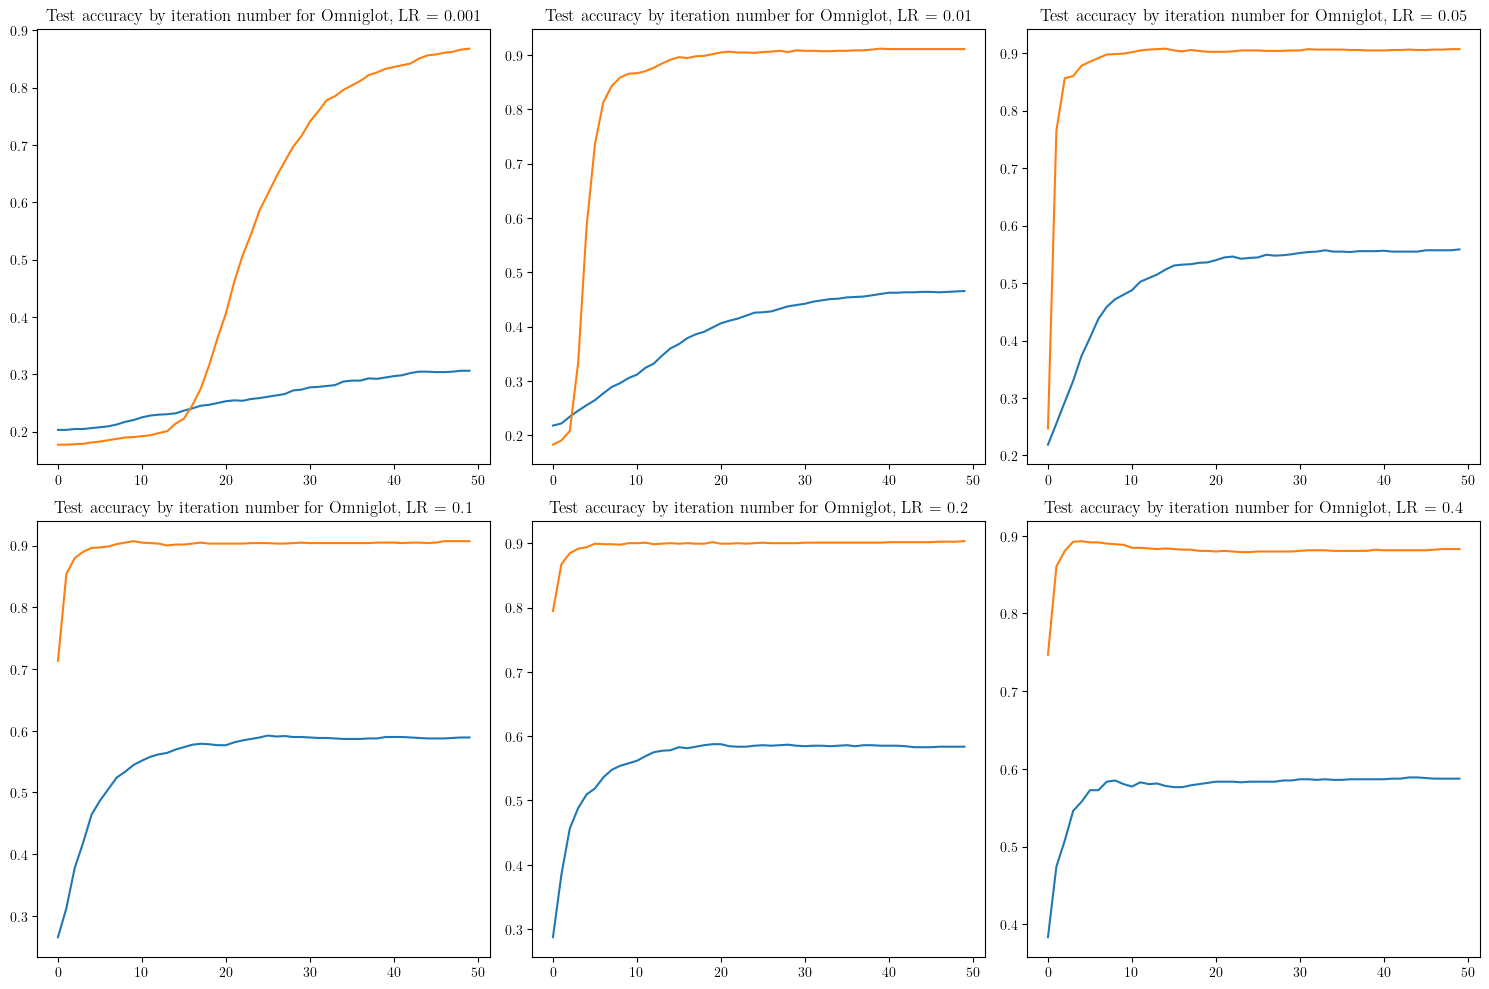

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for idx, lr in enumerate(lr_list):
    y0 = scratch_test_accuracies[str(lr)]
    y1 = maml_test_accuracies[str(lr)]
    axs[idx // 3, idx % 3].plot(np.array(list(range(len(y0)))), y0)
    axs[idx // 3, idx % 3].plot(np.array(list(range(len(y1)))), y1)
    axs[idx // 3, idx % 3].set_title(f'Test accuracy by iteration number for Omniglot, LR = {lr}')

plt.tight_layout()  # Adjust the layout to avoid overlapping titles and labels
plt.savefig('onn_omniglot_metalearning_comparison.jpg', format='jpg')
plt.show()

In [ ]:
for lr in lr_list:
    print(lr)
    print(scratch_test_accuracies[str(lr)])

In [ ]:
for lr in lr_list:
    print(lr)
    print(maml_test_accuracies[str(lr)])

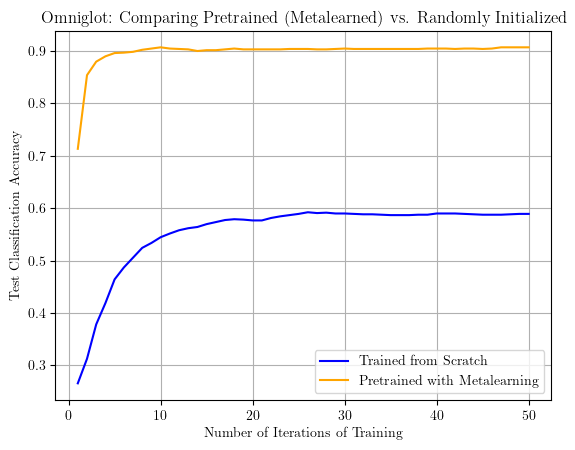

In [18]:
y0 = scratch_test_accuracies[str(0.1)]
y1 = maml_test_accuracies[str(0.1)]
plt.plot(np.array(list(range(1, len(y0)+1))), y0, label='Trained from Scratch', color='blue')
plt.plot(np.array(list(range(1,len(y1)+1))), y1, label='Pretrained with Metalearning', color='orange')

# Customize the plot
plt.xlabel('Number of Iterations of Training')
plt.ylabel('Test Classification Accuracy')
plt.title('Omniglot: Comparing Pretrained ONN (Metalearned) vs. Randomly Initialized ONN')
plt.grid(True)
plt.legend()
plt.savefig('omniglot_metalearning_comparison_lr=0.1.jpg', format='jpg')
plt.show()